# 10-test-stl.ipynb

This notebook performs the segmentation workflow adapted for the compressed F50 sand experiment and adds a step to convert the segmented voxels to tri-meshes to be saved as STLs.

# Import packages

In [1]:
# Set to False to use matplotlib.pyplot to view 2D images one at a time
use_napari = False
# Standard library imports
import math
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
if use_napari:
    import napari
import numpy as np
from skimage import color, exposure, filters, measure
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

# Load 3D data

In [2]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path(module_path) / r'data\SandComp4_18_22\NoComptiff',
    return_3d_array=True,
    convert_to_float=True,
    file_suffix='tiff'
)
print(f'Images loaded as 3D array: {imgs.shape}')

Images loaded as 3D array: (248, 1024, 343)


In [3]:
# Show images with napari
if use_napari:
    # Open napari viewer
    viewer = napari.Viewer()
    viewer.add_image(imgs)

## Crop Data

In [4]:
def crop_data(imgs, slice_lims=None, row_lims=None, col_lims=None):
    if slice_lims is None:
        slice_lims = [0, imgs.shape[0]]
    if row_lims is None:
        row_lims = [0, imgs.shape[1]]
    if col_lims is None:
        col_lims = [0, imgs.shape[2]]
    return imgs[
        slice_lims[0]:slice_lims[1], 
        row_lims[0]:row_lims[1], 
        col_lims[0]:col_lims[1]
    ]

In [5]:
imgs_cropped = crop_data(
    imgs, slice_lims=[75, 175], row_lims=[450, 600], col_lims=[100, 250]
)
imgs_cropped.shape

(100, 150, 150)

# Binarize data

In [6]:
def binarize_multiotsu(imgs, n_regions):
    imgs_binarized = np.zeros_like(imgs, dtype=np.float32)
    imgs_flat = imgs.flatten()
    imgs_binarized = np.zeros_like(imgs, dtype=np.float32)
    thresh_vals = filters.threshold_multiotsu(imgs_flat, n_regions)
    imgs_binarized[imgs > thresh_vals[-1]] = 1
    return imgs_binarized, thresh_vals

In [7]:
imgs_binarized, thresh_vals = binarize_multiotsu(imgs_cropped, 2)

# Segment Data

In [31]:
segment_dict = segment.watershed_segment(
    imgs_binarized, 
    min_peak_distance=7, 
    return_dict=True
)

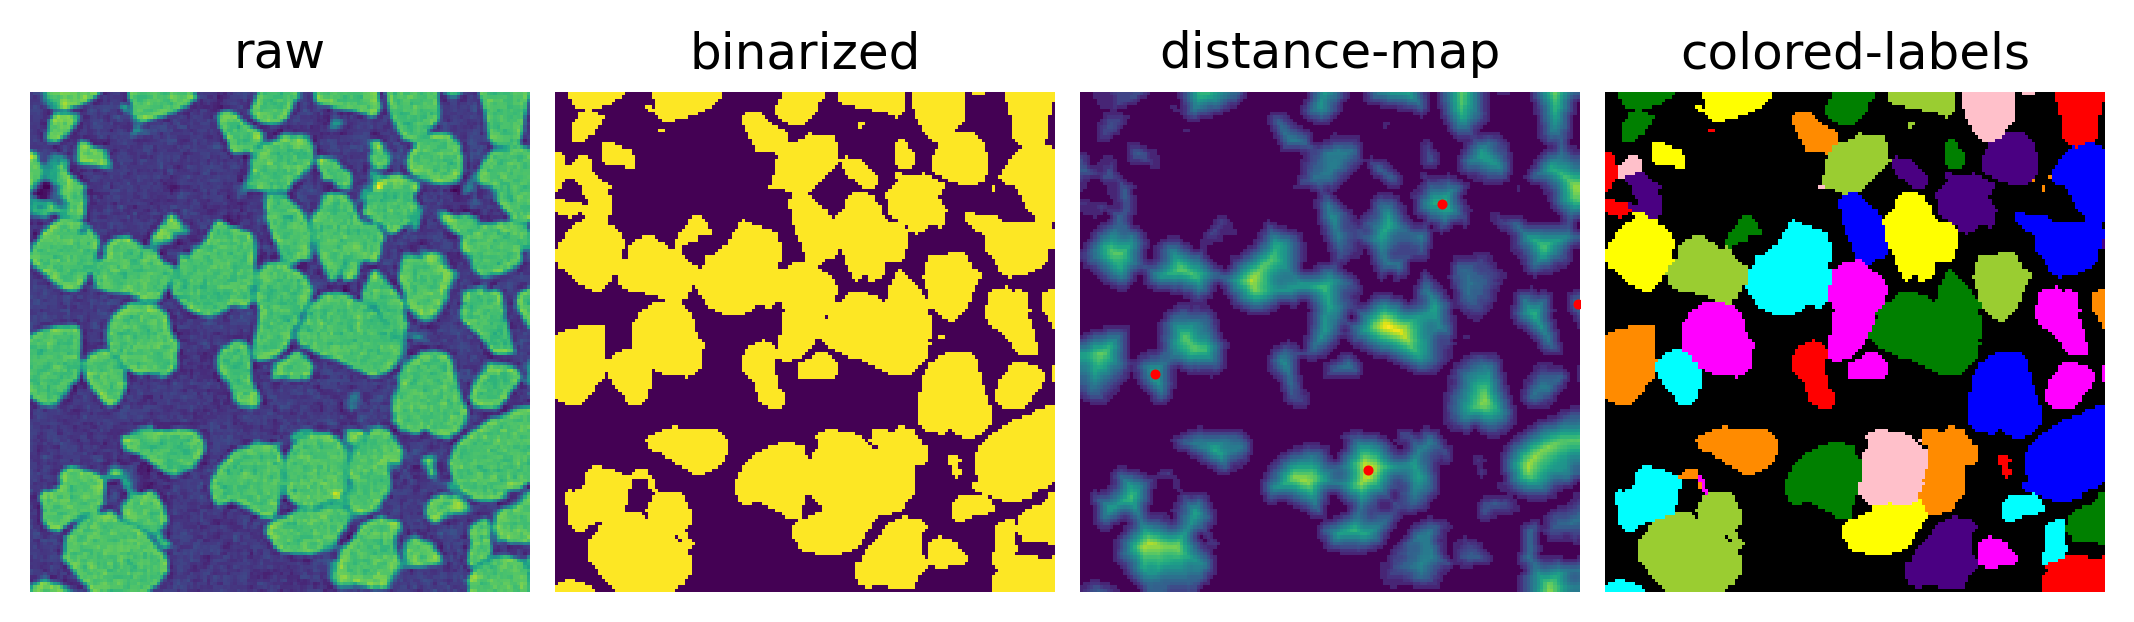

In [32]:
fig, axes = segment.plot_segment_steps(imgs_cropped, segment_dict, 55)
plt.show()